# Section 1: Importing Data and testing format is set up correctly

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Set up path to data folder
import os

DATA_ROOT = '/content/drive/MyDrive/DATA 2050: ML & MRIs /UCSF-PDGM-v5'

['UCSF-PDGM-0540_DTI_eddy.eddy_rotated_bvecs', 'UCSF-PDGM-0540_DTI_eddy_MD.nii.gz', 'UCSF-PDGM-0540_DTI_eddy_FA.nii.gz', 'UCSF-PDGM-0540_ASL.nii.gz', 'UCSF-PDGM-0540_DTI_eddy_L2.nii.gz', 'UCSF-PDGM-0540_DTI_eddy_L1.nii.gz', 'UCSF-PDGM-0540_ADC.nii.gz', 'UCSF-PDGM-0540_DTI_eddy_L3.nii.gz', 'UCSF-PDGM-0540_DWI_bias.nii.gz', 'UCSF-PDGM-0540_DWI.nii.gz', 'UCSF-PDGM-0540_DTI_eddy_noreg.nii.gz', 'UCSF-PDGM-0540_FLAIR_bias.nii.gz', 'UCSF-PDGM-0540_FLAIR.nii.gz', 'UCSF-PDGM-0540_SWI_bias.nii.gz', 'UCSF-PDGM-0540_T1_bias.nii.gz', 'UCSF-PDGM-0540_SWI.nii.gz', 'UCSF-PDGM-0540_tumor_segmentation.nii.gz', 'UCSF-PDGM-0540_brain_segmentation.nii.gz', 'UCSF-PDGM-0540_T1.nii.gz', 'UCSF-PDGM-0540_brain_parenchyma_segmentation.nii.gz', 'UCSF-PDGM-0540_T1c.nii.gz', 'UCSF-PDGM-0540_T1c_bias.nii.gz', 'UCSF-PDGM-0540_T2.nii.gz', 'UCSF-PDGM-0540_T2_bias.nii.gz']


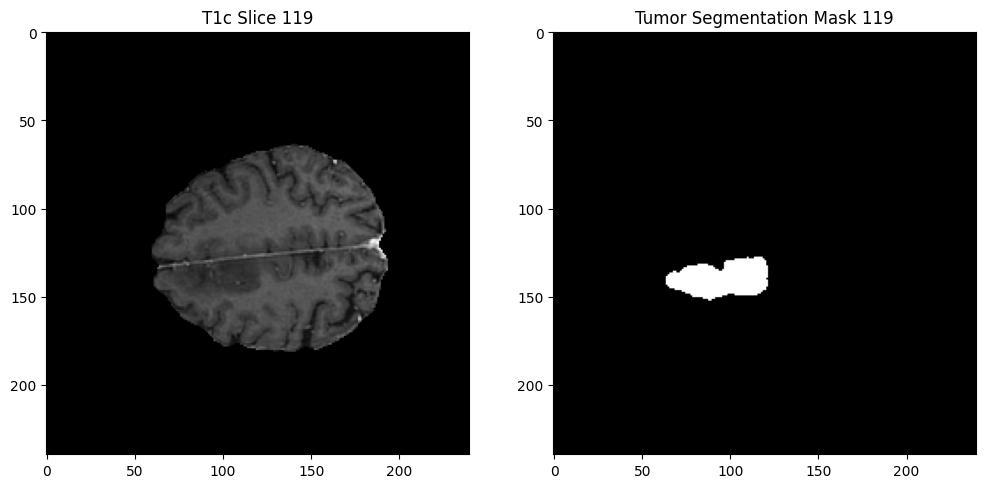

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt


#Test patient folder to ensure it's set up correctly
sample_patient_id = 'UCSF-PDGM-0540_nifti'
sample_patient_path = os.path.join(DATA_ROOT, sample_patient_id)

print(os.listdir(sample_patient_path))

#Load and Visualize an MRI and Segmentation Mask

# Load T1c and segmentation mask
# Define expected file paths
t1c_path = os.path.join(sample_patient_path, f'{sample_patient_id.replace("_nifti", "")}_T1c.nii.gz')
mask_path = os.path.join(sample_patient_path, f'{sample_patient_id.replace("_nifti", "")}_tumor_segmentation.nii.gz')

# Load mask image
mask_img = nib.load(mask_path).get_fdata()

# Load and preprocess T1c image
t1c_img = nib.load(t1c_path).get_fdata()
t1c_img = (t1c_img - np.mean(t1c_img)) / np.std(t1c_img)  # z-score normalization

# Find a slice index with tumor in it
non_empty_slices = [i for i in range(mask_img.shape[2]) if np.sum(mask_img[:, :, i]) > 0]

if non_empty_slices:
    # Pick the central tumor slice
    slice_idx = non_empty_slices[len(non_empty_slices) // 2]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(t1c_img[:, :, slice_idx], cmap='gray')
    plt.title(f'T1c Slice {slice_idx}')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_img[:, :, slice_idx], cmap='gray')
    plt.title(f'Tumor Segmentation Mask {slice_idx}')
    plt.show()
else:
    print("❌ No tumor present in any slice of this mask.")

# Section 2: Filtering Valid Patient Folders

In [ ]:
#Store good patient IDs here
valid_patients = []

# Loop over all patient folders
for patient_folder in sorted(os.listdir(DATA_ROOT)):
    full_path = os.path.join(DATA_ROOT, patient_folder)

    # Only check folders
    if not os.path.isdir(full_path):
        continue

    patient_id = patient_folder.replace('_nifti', '')  # e.g., UCSF-PDGM-0540

    # Build paths to T1c and mask
    t1c_path = os.path.join(full_path, f'{patient_id}_T1c.nii.gz')
    mask_path = os.path.join(full_path, f'{patient_id}_tumor_segmentation.nii.gz')

    try:
        # Check both files exist
        if not os.path.exists(t1c_path) or not os.path.exists(mask_path):
            continue

        # Load both files
        t1c = nib.load(t1c_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Basic quality checks
        if t1c.shape != mask.shape:
            continue
        if np.sum(mask) == 0:
            continue

        valid_patients.append(patient_id)

    except nib.filebasedimages.ImageFileError:
        continue
    except Exception as e:
        print(f"⚠️ Skipping {patient_id} due to error: {e}")
        continue

print(f"✅ Found {len(valid_patients)} valid patients.")
print(valid_patients[:5])

✅ Found 500 valid patients.
['UCSF-PDGM-0004', 'UCSF-PDGM-0005', 'UCSF-PDGM-0007', 'UCSF-PDGM-0008', 'UCSF-PDGM-0009']


#Section 3: Load & Clean valid MRI/mask pairs


In [ ]:
import torch
import torch.nn.functional as F

def center_crop_or_pad_3d(volume, target_shape=(128, 128, 128)):
    """
    Applies center crop or symmetric padding to a 3D volume.
    Expects input shape: [1, D, H, W]
    """
    _, D, H, W = volume.shape
    target_D, target_H, target_W = target_shape

    # Padding or cropping logic
    def _get_slices_or_pads(old_size, new_size):
        if old_size >= new_size:
            start = (old_size - new_size) // 2
            return slice(start, start + new_size), None  # cropping
        else:
            pad = (new_size - old_size) // 2
            return slice(0, old_size), (pad, new_size - old_size - pad)  # padding

    d_slice, d_pad = _get_slices_or_pads(D, target_D)
    h_slice, h_pad = _get_slices_or_pads(H, target_H)
    w_slice, w_pad = _get_slices_or_pads(W, target_W)

    # Crop first
    volume = volume[:, d_slice, h_slice, w_slice]

    # Pad if needed
    if d_pad or h_pad or w_pad:
        pads = []
        for pad in [w_pad, h_pad, d_pad]:  # reverse order for F.pad
            pads.extend([pad[0], pad[1]] if pad else [0, 0])
        volume = F.pad(volume, pads)

    return volume

In [ ]:
import torch
from torch.utils.data import Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, patient_ids, data_root, modality='T1c', transform=None):
        self.patient_ids = patient_ids
        self.data_root = data_root
        self.modality = modality
        self.transform = transform

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
      patient_id = self.patient_ids[idx]
      folder_name = f"{patient_id}_nifti"
      folder_path = os.path.join(self.data_root, folder_name)

      img_path = os.path.join(folder_path, f"{patient_id}_{self.modality}.nii.gz")
      mask_path = os.path.join(folder_path, f"{patient_id}_tumor_segmentation.nii.gz")

      # Load MRI and mask
      img = nib.load(img_path).get_fdata()
      mask = nib.load(mask_path).get_fdata()

      # Normalize MRI
      img = (img - np.mean(img)) / np.std(img)

      # Convert to torch tensors
      img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)    # shape: [1, D, H, W]
      mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # shape: [1, D, H, W]

      # 🔹 Add this part
      img = center_crop_or_pad_3d(img, target_shape=(128, 128, 128))
      mask = center_crop_or_pad_3d(mask, target_shape=(128, 128, 128))

      # Optional transforms
      if self.transform:
          img, mask = self.transform(img, mask)

      return img, mask

In [ ]:
import pandas as pd
import torch

def extract_features(img_tensor, mask_tensor, patient_id):
    """
    Inputs: tensors with shape [1, D, H, W]
    Outputs: dict of features
    """
    img = img_tensor.squeeze().numpy()
    mask = mask_tensor.squeeze().numpy()

    # Masked tumor region
    tumor_voxels = img[mask > 0]

    if tumor_voxels.size == 0:
        return None  # skip empty masks (shouldn't happen due to filtering)

    # Bounding box
    coords = np.argwhere(mask > 0)
    min_z, min_y, min_x = coords.min(axis=0)
    max_z, max_y, max_x = coords.max(axis=0)
    bbox_size = (max_x - min_x + 1, max_y - min_y + 1, max_z - min_z + 1)

    # Centroid
    centroid = coords.mean(axis=0)

    # Volume
    volume = tumor_voxels.size

    # Intensity stats
    return {
        "patient_id": patient_id,
        "tumor_volume": volume,
        "tumor_mean_intensity": np.mean(tumor_voxels),
        "tumor_std_intensity": np.std(tumor_voxels),
        "bbox_size_x": bbox_size[0],
        "bbox_size_y": bbox_size[1],
        "bbox_size_z": bbox_size[2],
        "centroid_x": centroid[2],  # x = width
        "centroid_y": centroid[1],  # y = height
        "centroid_z": centroid[0],  # z = depth
    }

In [ ]:
features = []

for pid in valid_patients:
    img, mask = BrainTumorDataset([pid], DATA_ROOT)[0]  # get one sample
    feats = extract_features(img, mask, pid)
    if feats:
        features.append(feats)

# Convert to dataframe
features_df = pd.DataFrame(features)
print(features_df.head())

       patient_id  tumor_volume  tumor_mean_intensity  tumor_std_intensity  \
0  UCSF-PDGM-0004         41919              2.902153             1.648282   
1  UCSF-PDGM-0005         28419              2.645519             0.763906   
2  UCSF-PDGM-0007        223623              1.491889             0.800455   
3  UCSF-PDGM-0008        165970              2.068540             1.315190   
4  UCSF-PDGM-0009        119081              2.252659             0.699124   

   bbox_size_x  bbox_size_y  bbox_size_z  centroid_x  centroid_y  centroid_z  
0           46           50           44   91.564994   98.122283  105.891887  
1           58           54           49   70.694043   75.582322   32.575601  
2           79          110           75   74.615464   65.497404   30.230263  
3           78           93           66   76.918232   85.986961   30.554281  
4           62           84           59   97.745224   43.261217   89.444722  


#Section 4: Merge with Metadata

In [ ]:
import pandas as pd

# Replace this with the actual path if different
metadata_path = '/content/drive/MyDrive/DATA 2050: ML & MRIs /UCSF-Metadata/UCSF-PDGM-metadata_v5.csv'

# Load metadata
metadata_df = pd.read_csv(metadata_path)

#Edit ID column to match the MRI dataset
metadata_df.rename(columns={'ID': 'patient_id'}, inplace=True)
metadata_df['patient_id'] = metadata_df['patient_id'].apply(
    lambda x: 'UCSF-PDGM-' + x.split('-')[-1].zfill(4)
)

print(metadata_df.head())

       patient_id Sex  Age at MRI  WHO CNS Grade  \
0  UCSF-PDGM-0004   M          66              4   
1  UCSF-PDGM-0005   F          80              4   
2  UCSF-PDGM-0007   M          70              4   
3  UCSF-PDGM-0008   M          70              4   
4  UCSF-PDGM-0009   F          68              4   

  Final pathologic diagnosis (WHO 2021)    MGMT status MGMT index   1p/19q  \
0            Glioblastoma, IDH-wildtype       negative          0  unknown   
1            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown   
2            Glioblastoma, IDH-wildtype  indeterminate    unknown  unknown   
3            Glioblastoma, IDH-wildtype       negative          0  unknown   
4            Glioblastoma, IDH-wildtype       negative          0  unknown   

        IDH  1-dead 0-alive      OS     EOR Biopsy prior to imaging  \
0  wildtype               1  1303.0     STR                      No   
1  wildtype               1   274.0  biopsy                      No   
2  wi

In [ ]:
# Merge datasets on patient ID
merged_df = pd.merge(features_df, metadata_df, on='patient_id', how='inner')

print(merged_df.shape)
print(merged_df.head())

(500, 25)
       patient_id  tumor_volume  tumor_mean_intensity  tumor_std_intensity  \
0  UCSF-PDGM-0004         41919              2.902153             1.648282   
1  UCSF-PDGM-0005         28419              2.645519             0.763906   
2  UCSF-PDGM-0007        223623              1.491889             0.800455   
3  UCSF-PDGM-0008        165970              2.068540             1.315190   
4  UCSF-PDGM-0009        119081              2.252659             0.699124   

   bbox_size_x  bbox_size_y  bbox_size_z  centroid_x  centroid_y  centroid_z  \
0           46           50           44   91.564994   98.122283  105.891887   
1           58           54           49   70.694043   75.582322   32.575601   
2           79          110           75   74.615464   65.497404   30.230263   
3           78           93           66   76.918232   85.986961   30.554281   
4           62           84           59   97.745224   43.261217   89.444722   

   ... MGMT index   1p/19q       IDH 1-d

In [ ]:
#See the WHO CNS Grade
print(merged_df['WHO CNS Grade'].unique())

[4 3 2]


#Section 5:EDA

Class distribution (WHO CNS Grade):
WHO CNS Grade
2     56
3     43
4    401
Name: count, dtype: int64


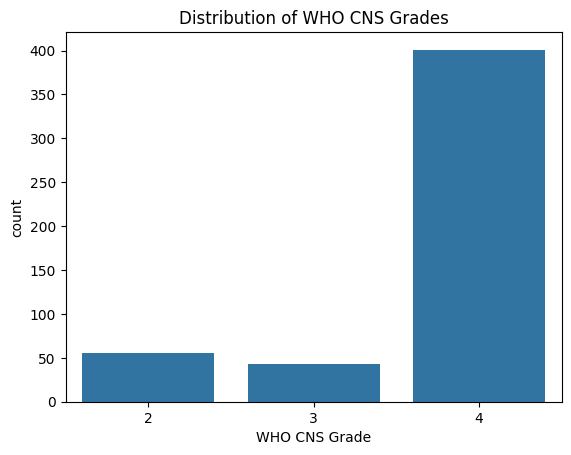


Missing values per column:
BraTS21 MGMT Cohort            217
BraTS21 Segmentation Cohort    202
BraTS21 ID                     202
OS                               1
EOR                              1
dtype: int64

Feature types:
patient_id                                object
tumor_volume                               int64
tumor_mean_intensity                     float32
tumor_std_intensity                      float32
bbox_size_x                                int64
bbox_size_y                                int64
bbox_size_z                                int64
centroid_x                               float64
centroid_y                               float64
centroid_z                               float64
Sex                                       object
Age at MRI                                 int64
WHO CNS Grade                              int64
Final pathologic diagnosis (WHO 2021)     object
MGMT status                               object
MGMT index                       

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check class distribution
print("Class distribution (WHO CNS Grade):")
print(merged_df['WHO CNS Grade'].value_counts().sort_index())

# Plot it
sns.countplot(data=merged_df, x='WHO CNS Grade')
plt.title("Distribution of WHO CNS Grades")
plt.show()

# Check for missing values
missing = merged_df.isnull().sum()
print("\nMissing values per column:")
print(missing[missing > 0].sort_values(ascending=False))

# Overview of dtypes
print("\nFeature types:")
print(merged_df.dtypes)

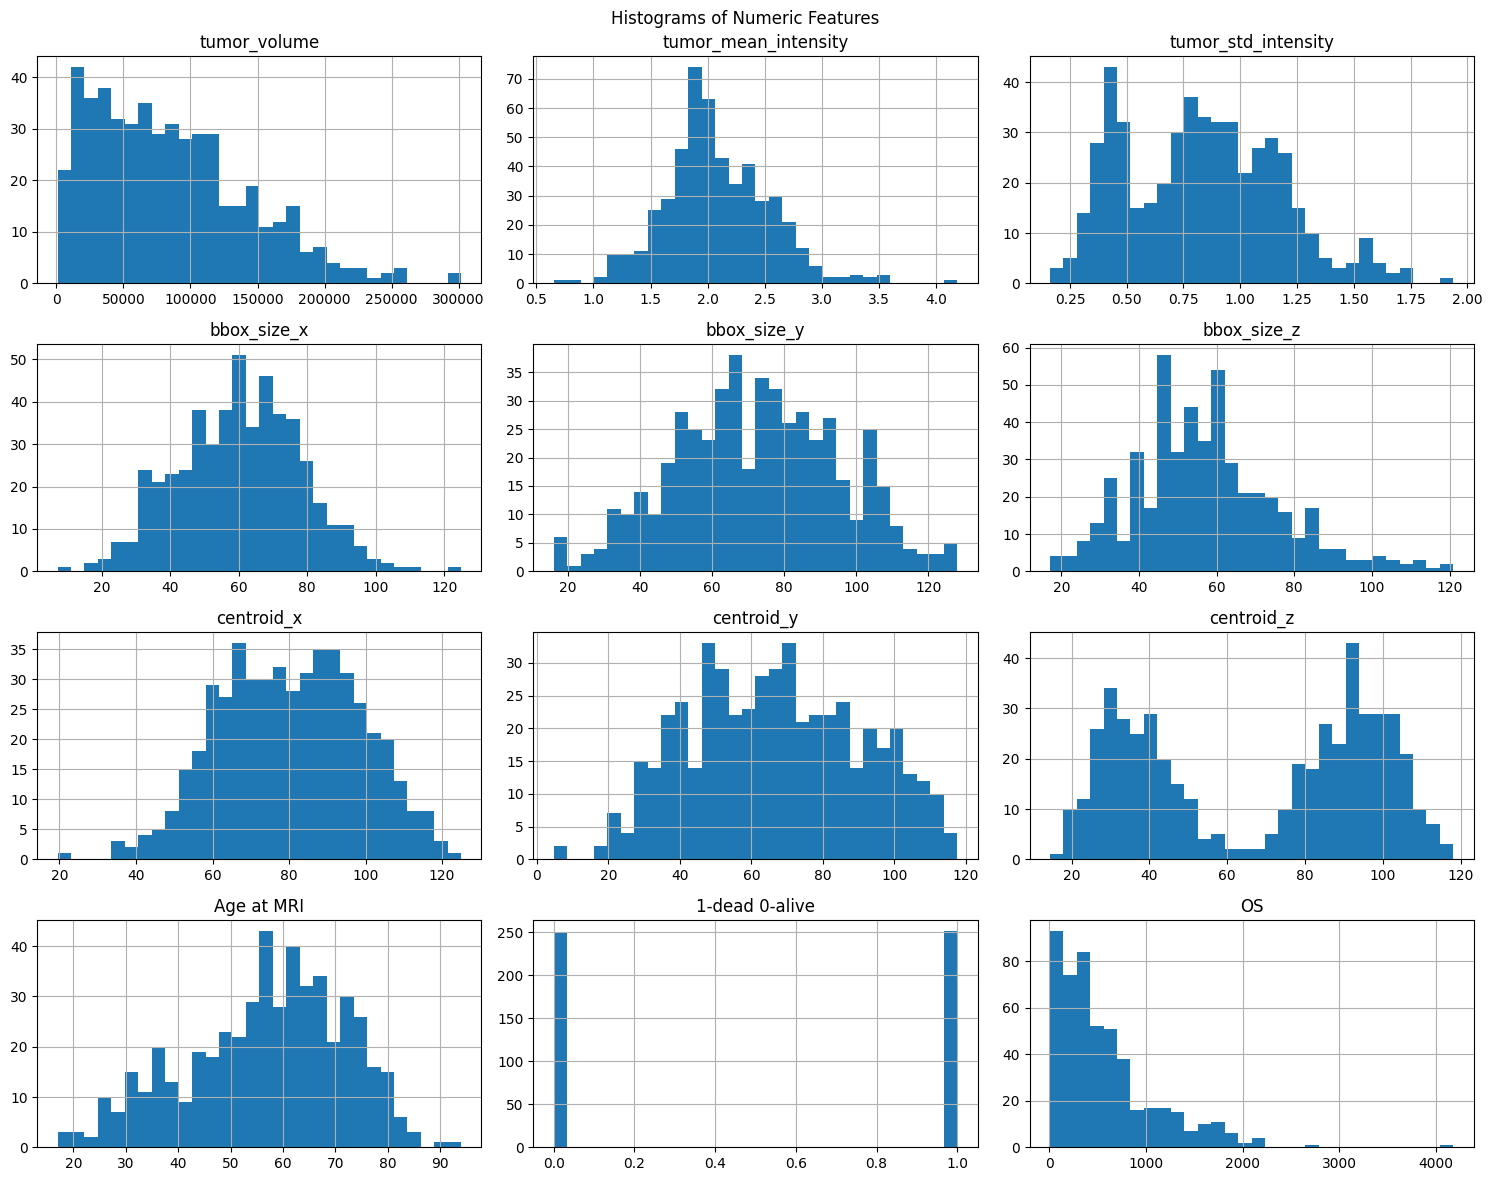

In [ ]:
# Select numeric features (excluding patient_id)
numeric_cols = merged_df.select_dtypes(include='number').drop(columns=['WHO CNS Grade'])

# Histograms for all numeric features
merged_df[numeric_cols.columns].hist(bins=30, figsize=(15, 12))
plt.suptitle("Histograms of Numeric Features")
plt.tight_layout()
plt.show()

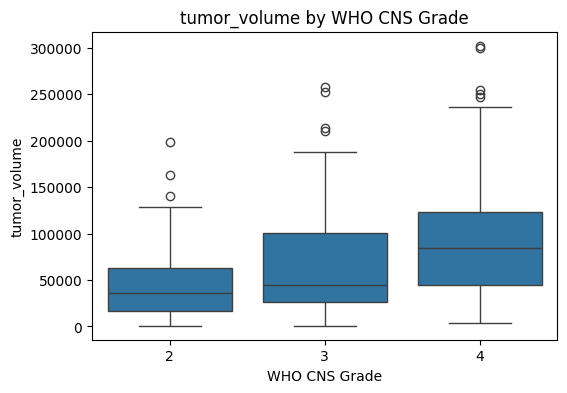

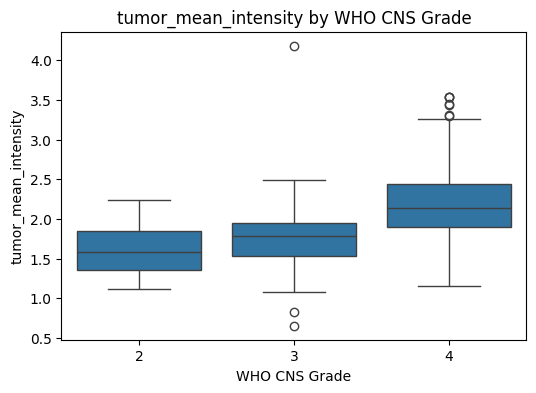

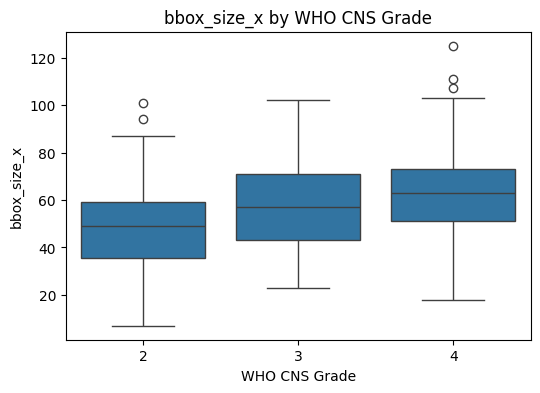

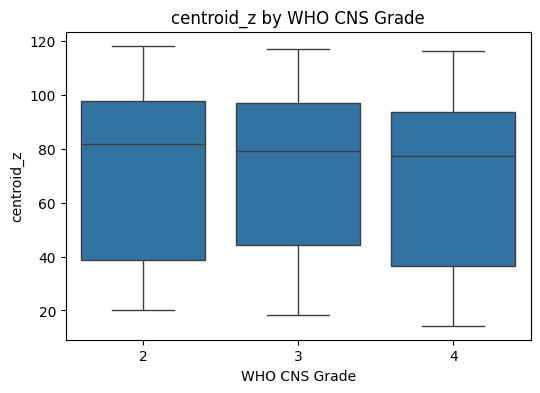

In [ ]:
# Boxplots of top features grouped by grade
features_to_plot = ['tumor_volume', 'tumor_mean_intensity', 'bbox_size_x', 'centroid_z']

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=merged_df, x='WHO CNS Grade', y=feature)
    plt.title(f"{feature} by WHO CNS Grade")
    plt.show()

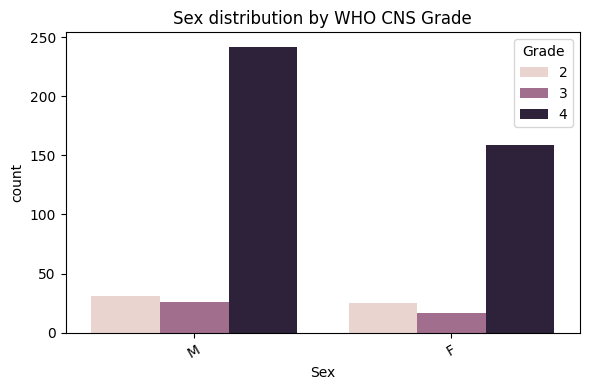

In [ ]:
categorical_cols = ['Sex']

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=merged_df, x=col, hue='WHO CNS Grade')
    plt.title(f"{col} distribution by WHO CNS Grade")
    plt.xticks(rotation=30)
    plt.legend(title='Grade')
    plt.tight_layout()
    plt.show()

#Section 6: Prepare Data for AlexNet Model



###Preprocess Metadata

In [ ]:
#Check NAs
cols_to_check = [
    'Sex',
    'Age at MRI',
    'MGMT status',
    'MGMT index',
    '1p/19q',
    'IDH',
    'OS',
    'WHO CNS Grade'
]

# Print NA counts
na_counts = merged_df[cols_to_check].isna().sum()
print("🔍 Missing values per column:")
print(na_counts.sort_values(ascending=False))

🔍 Missing values per column:
OS               1
Sex              0
MGMT status      0
Age at MRI       0
MGMT index       0
1p/19q           0
IDH              0
WHO CNS Grade    0
dtype: int64


In [ ]:
import numpy as np

metadata_clean = merged_df.copy()

# Sex: M → 0, F → 1
metadata_clean['Sex'] = metadata_clean['Sex'].map({'M': 0, 'F': 1})

# MGMT status: positive → 1, negative → 0, unknown/indeterminate → NaN
mgmt_map = {'positive': 1, 'negative': 0}
metadata_clean['MGMT status'] = metadata_clean['MGMT status'].map(mgmt_map)

# IDH: wildtype → 0, all mutations → 1
metadata_clean['IDH'] = metadata_clean['IDH'].apply(
    lambda x: 0 if isinstance(x, str) and 'wildtype' in x.lower() else (
        1 if isinstance(x, str) else np.nan
    )
)

# 1p/19q: intact → 0, co-deletion/relative co-deletion → 1, unknown → NaN
p19q_map = {
    'co-deletion': 1,
    'relative co-deletion': 1,
    'intact': 0
}
metadata_clean['1p/19q'] = metadata_clean['1p/19q'].map(p19q_map)

# check for remaining missing values
print(metadata_clean[['Sex', 'MGMT status', 'IDH', '1p/19q']].isna().sum())

Sex             0
MGMT status    85
IDH             0
1p/19q         91
dtype: int64


In [ ]:
#Impute missing rows using mode
metadata_clean['MGMT status'].fillna(metadata_clean['MGMT status'].mode()[0], inplace=True)
metadata_clean['1p/19q'].fillna(metadata_clean['1p/19q'].mode()[0], inplace=True)

/tmp/ipython-input-21-1604190129.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata_clean['MGMT status'].fillna(metadata_clean['MGMT status'].mode()[0], inplace=True)
/tmp/ipython-input-21-1604190129.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

In [ ]:
# check for remaining missing values
print(metadata_clean[['Sex', 'MGMT status', 'IDH', '1p/19q']].isna().sum())

Sex            0
MGMT status    0
IDH            0
1p/19q         0
dtype: int64


In [ ]:
# Check mean and std of all columns
summary_stats = metadata_clean.describe().T[['mean', 'std']].round(3)
print(summary_stats)

                           mean        std
tumor_volume          84851.088  57819.944
tumor_mean_intensity      2.086      0.456
tumor_std_intensity       0.831      0.338
bbox_size_x              60.220     17.684
bbox_size_y              72.566     22.758
bbox_size_z              57.428     18.477
centroid_x               80.376     18.233
centroid_y               66.789     23.847
centroid_z               67.669     30.021
Sex                       0.402      0.491
Age at MRI               56.848     15.030
WHO CNS Grade             3.690      0.662
MGMT status               0.774      0.419
1p/19q                    0.030      0.171
IDH                       0.206      0.405
1-dead 0-alive            0.502      0.500
OS                      576.034    517.375


###Set up padding

In [ ]:
#center crop or pad a 2D slice to 128 x 128
def center_crop_or_pad_2d(slice_2d, target_shape=(128, 128)):
    h, w = slice_2d.shape
    th, tw = target_shape

    pad_h = max(0, (th - h) // 2)
    pad_w = max(0, (tw - w) // 2)

    crop_h = max(0, (h - th) // 2)
    crop_w = max(0, (w - tw) // 2)

    slice_2d = slice_2d[
        crop_h:crop_h + min(th, h),
        crop_w:crop_w + min(tw, w)
    ]

    slice_2d = np.pad(
        slice_2d,
        ((pad_h, th - slice_2d.shape[0] - pad_h),
         (pad_w, tw - slice_2d.shape[1] - pad_w)),
        mode='constant'
    )
    return slice_2d

In [ ]:
# Paths
output_dir = '/content/processed_slices_npy'
os.makedirs(output_dir, exist_ok=True)

#collect slices
slice_metadata = []

# Loop over patients in merged_df
for idx, row in merged_df.iterrows():
    pid = row['patient_id']
    label = row['WHO CNS Grade']
    folder = f"{pid}_nifti"
    t1c_path = os.path.join(DATA_ROOT, folder, f"{pid}_T1c.nii.gz")
    mask_path = os.path.join(DATA_ROOT, folder, f"{pid}_tumor_segmentation.nii.gz")

    try:
        t1c = nib.load(t1c_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()
    except:
        continue  # skip bad files

    # Normalize T1c
    t1c = (t1c - np.mean(t1c)) / np.std(t1c)

    # Get tumor slices
    tumor_slices = [i for i in range(mask.shape[2]) if np.sum(mask[:, :, i]) > 0]
    if not tumor_slices:
        continue

    mid = len(tumor_slices) // 2
    selected_slices = tumor_slices[max(0, mid - 1): mid + 2]  # 2–3 central slices

    for slice_idx in selected_slices:
        img_slice = t1c[:, :, slice_idx]
        cropped = center_crop_or_pad_2d(img_slice)

        filename = f"{pid}_slice_{slice_idx}.npy"
        filepath = os.path.join(output_dir, filename)
        np.save(filepath, cropped)

        # get metadata for this patient
        patient_meta = metadata_clean[metadata_clean['patient_id'] == pid]
        if patient_meta.empty:
            continue

        meta_row = patient_meta.drop(columns=['patient_id']).iloc[0].to_dict()
        meta_row.update({
            "filename": filename
        })
        slice_metadata.append(meta_row)

# save CSV with metadata
slice_df = pd.DataFrame(slice_metadata)
csv_path = '/content/slice_metadata_with_labels.csv'
slice_df.to_csv(csv_path, index=False)

print(f"Saved {len(slice_df)} slices to {output_dir}")
print(f"Metadata CSV saved to {csv_path}")

NameError: name 'merged_df' is not defined

In [ ]:
#Move datafiles to our shared folder
shared_folder = '/content/drive/MyDrive/DATA 2050: ML & MRIs '

!cp -r /content/processed_slices_npy "$shared_folder/"
!cp /content/slice_metadata_with_labels.csv "$shared_folder/"

cp: cannot stat '/content/slice_metadata_with_labels.csv': No such file or directory


In [ ]:
#Just want to see what it looks like for my own reference

slice_df = pd.read_csv('/content/slice_metadata_with_labels.csv')
print(slice_df.shape)  # Rows x columns

# Display the first 5 rows
slice_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/slice_metadata_with_labels.csv'

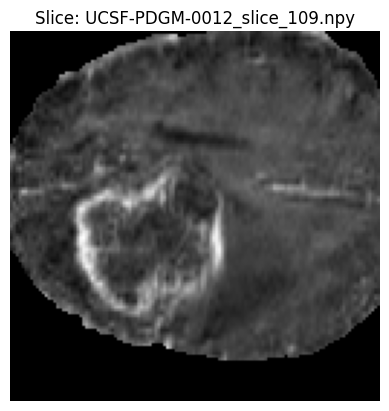

In [ ]:
import random


slice_dir = '/content/processed_slices_npy'

slice_files = os.listdir(slice_dir)
random_file = random.choice(slice_files)

slice_array = np.load(os.path.join(slice_dir, random_file))

plt.imshow(slice_array, cmap='gray')
plt.title(f"Slice: {random_file}")
plt.axis('off')
plt.show()


# Section 7: Run AlexNet and Baseline Models


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

class AlexNetWHO(nn.Module):
    """
    Modified AlexNet for WHO Grade Classification

    This is a CNN architecture based on the original AlexNet paper (Krizhevsky et al., 2012)
    but adapted for medical imaging:
    - Input: Single-channel 224x224 MRI slices (grayscale medical images)
    - Output: 4 classes representing WHO grades 1-4
    - Architecture: 5 convolutional layers + 3 fully connected layers

    Key modifications from original AlexNet:
    1. Single input channel (medical images are grayscale)
    2. Smaller classifier to prevent overfitting on medical data
    3. Adaptive pooling for flexible input sizes

    Args:
        num_classes (int): Number of WHO grade classes (default: 4 for grades 1-4)
    """
    def __init__(self, num_classes=4):
        super(AlexNetWHO, self).__init__()

        # Feature Extraction Layers
        # These convolutional layers learn spatial patterns in tumor images
        self.features = nn.Sequential(
            # Layer 1: Large receptive field to capture global tumor patterns
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),  # Non-linear activation
            nn.MaxPool2d(kernel_size=3, stride=2),  # Downsample to reduce computation

            # Layer 2: Detect more complex features
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Layer 3: Higher-level feature detection
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 4: Further feature refinement
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 5: Final convolutional features
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Adaptive pooling ensures consistent output size regardless of input variations
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # Classification Layers
        # These fully connected layers map visual features to WHO grade predictions
        self.classifier = nn.Sequential(
            # Regularization to prevent overfitting on small medical datasets
            nn.Dropout(0.5),

            # First FC layer: High-dimensional feature representation
            nn.Linear(256 * 6 * 6, 1024),  # 256 channels * 6*6 spatial = 9216 input features
            nn.ReLU(inplace=True),

            # Second FC layer: Intermediate feature compression
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            # Output layer: Final WHO grade prediction
            nn.Linear(256, num_classes),  # Maps to 4 WHO grades
        )

    def forward(self, x):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 224, 224)
                             representing MRI tumor slices

        Returns:
            torch.Tensor: Raw logits of shape (batch_size, num_classes)
                         Higher values indicate higher confidence for that WHO grade
        """
        # Extract spatial features using convolutional layers
        x = self.features(x)

        # Pool to fixed size and flatten for fully connected layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        # Classify based on extracted features
        x = self.classifier(x)

        return x

class SimpleBaseline(nn.Module):
    """
    Simple Fully-Connected Baseline Model

    This is a basic neural network that serves as a baseline comparison for AlexNet.
    It directly maps flattened pixel values to WHO grade predictions without
    considering spatial relationships in the image.

    Purpose:
    - Establish a simple baseline for comparison
    - If AlexNet can't beat this simple model, there might be issues with our approach
    - Common practice in deep learning to compare against simple baselines

    Architecture:
    - Flatten input image to 1D vector
    - Two fully connected layers with ReLU activation
    - Dropout for regularization

    Limitations:
    - Ignores spatial structure of medical images
    - Cannot capture local patterns or textures
    - Treats each pixel independently

    Args:
        num_classes (int): Number of WHO grade classes (default: 4)
    """
    def __init__(self, num_classes=4):
        super(SimpleBaseline, self).__init__()

        self.classifier = nn.Sequential(
            # Flatten 2D image to 1D vector
            nn.Flatten(),  # 224*224 = 50,176 features

            # Hidden layer: Learn basic feature combinations
            nn.Linear(224*224, 512),  # Map 50K pixels to 512 features
            nn.ReLU(inplace=True),

            # Regularization to prevent memorization
            nn.Dropout(0.5),

            # Output layer: Direct mapping to WHO grades
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        """
        Forward pass: Direct pixel-to-class mapping

        Args:
            x (torch.Tensor): Input MRI slice (batch_size, 1, 224, 224)

        Returns:
            torch.Tensor: WHO grade predictions (batch_size, num_classes)
        """
        return self.classifier(x)

def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001):
    """
    Train a neural network model for WHO grade classification

    This function implements a standard supervised learning training loop:
    1. Forward pass: Compute predictions from input images
    2. Loss calculation: Compare predictions with true WHO grades
    3. Backward pass: Compute gradients to update model parameters
    4. Validation: Monitor performance on unseen data to prevent overfitting

    Args:
        model (nn.Module): The neural network to train (AlexNet or Baseline)
        train_loader (DataLoader): Training data (MRI slices + WHO grade labels)
        val_loader (DataLoader): Validation data for monitoring overfitting
        num_epochs (int): Number of complete passes through training data
        lr (float): Learning rate - controls how much to update weights each step

    Returns:
        tuple: (trained_model, training_accuracies, validation_accuracies,
                training_f1_scores, validation_f1_scores)

    Training Strategy:
    - Adam optimizer: Adaptive learning rate for stable convergence
    - Cross-entropy loss: Standard for multi-class classification
    - Early stopping: Save best model based on combined accuracy and F1 score
    - Progress tracking: Monitor training progress with accuracy and F1 metrics
    """
    # Setup training environment
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")
    model.to(device)

    # Loss function: Cross-entropy for multi-class classification
    # Penalizes confident wrong predictions more than uncertain ones
    criterion = nn.CrossEntropyLoss()

    # Optimizer: Adam with weight decay for regularization
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # Track performance over time
    train_accs = []
    val_accs = []
    train_f1s = []
    val_f1s = []
    best_combined_score = 0
    best_model_state = None

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Training Phase: Update model parameters
        model.train()  # Enable dropout and batch norm training mode
        train_correct = 0
        train_total = 0
        train_predictions = []
        train_targets = []

        # Progress bar for user feedback
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')

        for batch_idx, (data, target) in enumerate(train_bar):
            # Move data to GPU if available
            data, target = data.to(device), target.to(device)

            # Forward pass: Get model predictions
            optimizer.zero_grad()  # Clear previous gradients
            output = model(data)   # Get WHO grade predictions

            # Calculate loss: How wrong are our predictions?
            loss = criterion(output, target)

            # Backward pass: Calculate gradients
            loss.backward()

            # Update model parameters based on gradients
            optimizer.step()

            # Track accuracy and F1 for monitoring
            _, predicted = torch.max(output, 1)  # Get predicted class
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            # Store predictions for F1 calculation
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(target.cpu().numpy())

            # Update progress bar with current accuracy
            current_acc = 100. * train_correct / train_total
            train_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{current_acc:.2f}%'})

        # Validation Phase: Check performance on unseen data
        model.eval()  # Disable dropout for consistent evaluation
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():  # Don't compute gradients during validation
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)

                # Get predictions without updating weights
                output = model(data)
                _, predicted = torch.max(output, 1)

                # Track validation accuracy and F1
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

                # Store predictions for F1 calculation
                val_predictions.extend(predicted.cpu().numpy())
                val_targets.extend(target.cpu().numpy())

        # Calculate epoch performance metrics
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        # Calculate F1 scores (macro average for multi-class)
        train_f1 = f1_score(train_targets, train_predictions, average='macro', zero_division=0)
        val_f1 = f1_score(val_targets, val_predictions, average='macro', zero_division=0)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Training Accuracy: {train_acc:.2f}%')
        print(f'  Training F1 Score: {train_f1:.4f}')
        print(f'  Validation Accuracy: {val_acc:.2f}%')
        print(f'  Validation F1 Score: {val_f1:.4f}')

        # Early stopping: Save best model based on combined accuracy and F1 score
        # Using harmonic mean (F1-like combination) of accuracy and F1 score
        combined_score = 2 * (val_acc/100 * val_f1) / (val_acc/100 + val_f1) if (val_acc/100 + val_f1) > 0 else 0

        if combined_score > best_combined_score:
            best_combined_score = combined_score
            best_model_state = model.state_dict().copy()
            print(f'  → New best combined score: {combined_score:.4f} (Acc: {val_acc:.2f}%, F1: {val_f1:.4f})')

        print('-' * 50)

    # Load the best performing model
    model.load_state_dict(best_model_state)
    print(f'\nTraining completed! Best combined score: {best_combined_score:.4f}')

    return model, train_accs, val_accs, train_f1s, val_f1s

def test_model(model, test_loader):
    """
    Evaluate trained model on held-out test data

    This function provides an unbiased estimate of model performance by testing
    on data that was never seen during training or validation.

    Args:
        model (nn.Module): Trained neural network
        test_loader (DataLoader): Test dataset with ground truth WHO grades

    Returns:
        tuple: (accuracy, f1_score, predictions, true_labels)
            - accuracy: Overall classification accuracy (0-1)
            - f1_score: Macro-averaged F1 score (0-1)
            - predictions: Model predictions for each test sample
            - true_labels: Ground truth WHO grades for comparison

    Why we need separate test data:
    - Training data: Used to learn model parameters
    - Validation data: Used to tune hyperparameters and prevent overfitting
    - Test data: Provides final, unbiased performance estimate
    """
    # Setup evaluation environment
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()  # Set to evaluation mode (disable dropout)

    # Collect all predictions and ground truth labels
    all_predictions = []
    all_targets = []

    print("Evaluating model on test data...")

    # Evaluate without updating model weights
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader, desc="Testing")):
            # Move data to appropriate device
            data, target = data.to(device), target.to(device)

            # Get model predictions
            output = model(data)

            # Convert logits to predicted classes
            _, predicted = torch.max(output, 1)

            # Store results for final analysis
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calculate overall test metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='macro', zero_division=0)

    print(f'Test Results:')
    print(f'  Total test samples: {len(all_targets)}')
    print(f'  Correct predictions: {int(accuracy * len(all_targets))}')
    print(f'  Test accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
    print(f'  Test F1 score (macro): {f1:.4f}')

    return accuracy, f1, all_predictions, all_targets

def create_alexnet(num_classes=4):
    """
    Factory function to create AlexNet model

    Args:
        num_classes (int): Number of WHO grade classes

    Returns:
        AlexNetWHO: Initialized AlexNet model for brain tumor classification
    """
    model = AlexNetWHO(num_classes=num_classes)

    # Print model information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"AlexNet Model Created:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")

    return model

def create_baseline(num_classes=4):
    """
    Factory function to create simple baseline model

    Args:
        num_classes (int): Number of WHO grade classes

    Returns:
        SimpleBaseline: Initialized baseline model for comparison
    """
    model = SimpleBaseline(num_classes=num_classes)

    # Print model information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Baseline Model Created:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")

    return model

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from PIL import Image
import os

class SliceDataset(Dataset):
    """
    PyTorch Dataset for loading preprocessed MRI slices and their WHO grade labels
    """
    def __init__(self, csv_path, slice_dir, transform=None):
        """
        Args:
            csv_path: Path to the metadata CSV file
            slice_dir: Directory containing the .npy slice files
            transform: Optional transforms to apply to the data
        """
        self.metadata = pd.read_csv(csv_path)
        self.slice_dir = slice_dir
        self.transform = transform

        # Convert WHO CNS Grade to 0-indexed labels for PyTorch
        # Assuming grades are 1, 2, 3, 4 -> convert to 0, 1, 2, 3
        self.metadata['label'] = self.metadata['WHO CNS Grade'] - 1

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get metadata for this sample
        row = self.metadata.iloc[idx]
        filename = row['filename']
        label = row['label']

        # Load the slice data
        slice_path = os.path.join(self.slice_dir, filename)
        slice_data = np.load(slice_path)

        # Convert to tensor and add channel dimension
        # Shape: (128, 128) -> (1, 128, 128)
        slice_tensor = torch.tensor(slice_data, dtype=torch.float32).unsqueeze(0)

        # Resize to 224x224 for AlexNet (which expects this input size)
        slice_tensor = torch.nn.functional.interpolate(
            slice_tensor.unsqueeze(0),
            size=(224, 224),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)

        label_tensor = torch.tensor(label, dtype=torch.long)

        if self.transform:
            slice_tensor = self.transform(slice_tensor)

        return slice_tensor, label_tensor

In [ ]:
csv_path = '/content/drive/MyDrive/DATA 2050: ML & MRIs /slice_metadata_with_labels.csv'
slice_dir = '/content/drive/MyDrive/DATA 2050: ML & MRIs /processed_slices_npy'

dataset = SliceDataset(csv_path, slice_dir)

In [ ]:
# Basic Train-Test Split
# train_size = int(0.7 * len(dataset))
# val_size = int(0.15 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# print(f"Split sizes - Train: {train_size}, Val: {val_size}, Test: {test_size}")

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



# Stratified Train-Test Split (no validation set)
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

indices = list(range(len(dataset)))
labels = [dataset[i][1].item() for i in indices]

train_indices, test_indices = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

print(f"Train: {len(train_indices)}, Test: {len(test_indices)}")

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Train: 1200, Test: 300


In [ ]:
# If do Basic Train-Test Split
# alexnet_model = create_alexnet()
# trained_alexnet, _, _, _, _ = train_model(alexnet_model, train_loader, val_loader, num_epochs=20)

# baseline_model = create_baseline()
# trained_baseline, _, _, _, _ = train_model(baseline_model, train_loader, val_loader, num_epochs=15)

# alexnet_accuracy, alexnet_f1, _, _ = test_model(trained_alexnet, test_loader)
# baseline_accuracy, baseline_f1, _, _ = test_model(trained_baseline, test_loader)


# If do Stratified
alexnet_model = create_alexnet()
trained_alexnet, _, _, _, _ = train_model(alexnet_model, train_loader, train_loader, num_epochs=20)

baseline_model = create_baseline()
trained_baseline, _, _, _, _ = train_model(baseline_model, train_loader, train_loader, num_epochs=15)

alexnet_accuracy, alexnet_f1, _, _ = test_model(trained_alexnet, test_loader)
baseline_accuracy, baseline_f1, _, _ = test_model(trained_baseline, test_loader)


# torch.save(trained_alexnet.state_dict(), '/content/drive/MyDrive/alexnet_model.pth')
# torch.save(trained_baseline.state_dict(), '/content/drive/MyDrive/baseline_model.pth')

AlexNet Model Created:
  Total parameters: 12,155,844
  Trainable parameters: 12,155,844
Training on device: cpu
Starting training for 20 epochs...


Epoch 1/20 [Training]: 100%|██████████| 75/75 [02:06<00:00,  1.69s/it, Loss=0.8504, Acc=78.25%]


Epoch 1/20:
  Training Accuracy: 78.25%
  Training F1 Score: 0.3169
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
  → New best combined score: 0.4333 (Acc: 80.25%, F1: 0.2968)
--------------------------------------------------


Epoch 2/20 [Training]: 100%|██████████| 75/75 [01:58<00:00,  1.59s/it, Loss=0.9156, Acc=80.25%]


Epoch 2/20:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 3/20 [Training]: 100%|██████████| 75/75 [02:02<00:00,  1.63s/it, Loss=0.6334, Acc=80.25%]


Epoch 3/20:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 4/20 [Training]: 100%|██████████| 75/75 [01:55<00:00,  1.54s/it, Loss=0.8726, Acc=80.25%]


Epoch 4/20:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 5/20 [Training]: 100%|██████████| 75/75 [01:55<00:00,  1.55s/it, Loss=0.4405, Acc=80.25%]


Epoch 5/20:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 6/20 [Training]: 100%|██████████| 75/75 [01:53<00:00,  1.51s/it, Loss=0.3089, Acc=80.25%]


Epoch 6/20:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 7/20 [Training]: 100%|██████████| 75/75 [01:54<00:00,  1.53s/it, Loss=0.2323, Acc=79.92%]


Epoch 7/20:
  Training Accuracy: 79.92%
  Training F1 Score: 0.3143
  Validation Accuracy: 80.83%
  Validation F1 Score: 0.4035
  → New best combined score: 0.5383 (Acc: 80.83%, F1: 0.4035)
--------------------------------------------------


Epoch 8/20 [Training]: 100%|██████████| 75/75 [01:55<00:00,  1.54s/it, Loss=0.5404, Acc=81.25%]


Epoch 8/20:
  Training Accuracy: 81.25%
  Training F1 Score: 0.3886
  Validation Accuracy: 82.75%
  Validation F1 Score: 0.4716
  → New best combined score: 0.6008 (Acc: 82.75%, F1: 0.4716)
--------------------------------------------------


Epoch 9/20 [Training]: 100%|██████████| 75/75 [01:53<00:00,  1.51s/it, Loss=0.4615, Acc=81.25%]


Epoch 9/20:
  Training Accuracy: 81.25%
  Training F1 Score: 0.4098
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 10/20 [Training]: 100%|██████████| 75/75 [01:54<00:00,  1.53s/it, Loss=0.3951, Acc=82.17%]


Epoch 10/20:
  Training Accuracy: 82.17%
  Training F1 Score: 0.4481
  Validation Accuracy: 81.08%
  Validation F1 Score: 0.3706
--------------------------------------------------


Epoch 11/20 [Training]: 100%|██████████| 75/75 [01:56<00:00,  1.56s/it, Loss=0.4597, Acc=82.33%]


Epoch 11/20:
  Training Accuracy: 82.33%
  Training F1 Score: 0.4837
  Validation Accuracy: 80.75%
  Validation F1 Score: 0.4817
  → New best combined score: 0.6034 (Acc: 80.75%, F1: 0.4817)
--------------------------------------------------


Epoch 12/20 [Training]: 100%|██████████| 75/75 [01:54<00:00,  1.52s/it, Loss=0.1953, Acc=82.33%]


Epoch 12/20:
  Training Accuracy: 82.33%
  Training F1 Score: 0.4736
  Validation Accuracy: 85.42%
  Validation F1 Score: 0.5429
  → New best combined score: 0.6639 (Acc: 85.42%, F1: 0.5429)
--------------------------------------------------


Epoch 13/20 [Training]: 100%|██████████| 75/75 [01:56<00:00,  1.56s/it, Loss=0.2076, Acc=85.00%]


Epoch 13/20:
  Training Accuracy: 85.00%
  Training F1 Score: 0.5993
  Validation Accuracy: 89.67%
  Validation F1 Score: 0.7263
  → New best combined score: 0.8025 (Acc: 89.67%, F1: 0.7263)
--------------------------------------------------


Epoch 14/20 [Training]: 100%|██████████| 75/75 [01:57<00:00,  1.57s/it, Loss=0.3225, Acc=88.33%]


Epoch 14/20:
  Training Accuracy: 88.33%
  Training F1 Score: 0.6973
  Validation Accuracy: 90.50%
  Validation F1 Score: 0.7443
  → New best combined score: 0.8168 (Acc: 90.50%, F1: 0.7443)
--------------------------------------------------


Epoch 15/20 [Training]: 100%|██████████| 75/75 [01:57<00:00,  1.57s/it, Loss=0.2761, Acc=90.67%]


Epoch 15/20:
  Training Accuracy: 90.67%
  Training F1 Score: 0.7571
  Validation Accuracy: 93.67%
  Validation F1 Score: 0.8528
  → New best combined score: 0.8928 (Acc: 93.67%, F1: 0.8528)
--------------------------------------------------


Epoch 16/20 [Training]: 100%|██████████| 75/75 [02:03<00:00,  1.65s/it, Loss=0.0480, Acc=90.42%]


Epoch 16/20:
  Training Accuracy: 90.42%
  Training F1 Score: 0.7697
  Validation Accuracy: 95.58%
  Validation F1 Score: 0.8961
  → New best combined score: 0.9250 (Acc: 95.58%, F1: 0.8961)
--------------------------------------------------


Epoch 17/20 [Training]: 100%|██████████| 75/75 [02:11<00:00,  1.75s/it, Loss=0.0702, Acc=92.50%]


Epoch 17/20:
  Training Accuracy: 92.50%
  Training F1 Score: 0.8107
  Validation Accuracy: 95.33%
  Validation F1 Score: 0.8786
--------------------------------------------------


Epoch 18/20 [Training]: 100%|██████████| 75/75 [02:19<00:00,  1.86s/it, Loss=0.1920, Acc=94.42%]


Epoch 18/20:
  Training Accuracy: 94.42%
  Training F1 Score: 0.8581
  Validation Accuracy: 97.33%
  Validation F1 Score: 0.9334
  → New best combined score: 0.9529 (Acc: 97.33%, F1: 0.9334)
--------------------------------------------------


Epoch 19/20 [Training]: 100%|██████████| 75/75 [02:23<00:00,  1.92s/it, Loss=0.0958, Acc=94.50%]


Epoch 19/20:
  Training Accuracy: 94.50%
  Training F1 Score: 0.8633
  Validation Accuracy: 97.17%
  Validation F1 Score: 0.9296
--------------------------------------------------


Epoch 20/20 [Training]: 100%|██████████| 75/75 [02:32<00:00,  2.03s/it, Loss=0.0557, Acc=96.25%]


Epoch 20/20:
  Training Accuracy: 96.25%
  Training F1 Score: 0.9036
  Validation Accuracy: 97.42%
  Validation F1 Score: 0.9461
  → New best combined score: 0.9599 (Acc: 97.42%, F1: 0.9461)
--------------------------------------------------

Training completed! Best combined score: 0.9599
Baseline Model Created:
  Total parameters: 25,692,676
  Trainable parameters: 25,692,676
Training on device: cpu
Starting training for 15 epochs...


Epoch 1/15 [Training]: 100%|██████████| 75/75 [00:40<00:00,  1.84it/s, Loss=5.8343, Acc=66.08%]


Epoch 1/15:
  Training Accuracy: 66.08%
  Training F1 Score: 0.2554
  Validation Accuracy: 74.25%
  Validation F1 Score: 0.3741
  → New best combined score: 0.4976 (Acc: 74.25%, F1: 0.3741)
--------------------------------------------------


Epoch 2/15 [Training]: 100%|██████████| 75/75 [00:37<00:00,  2.00it/s, Loss=0.5482, Acc=74.33%]


Epoch 2/15:
  Training Accuracy: 74.33%
  Training F1 Score: 0.2667
  Validation Accuracy: 80.33%
  Validation F1 Score: 0.3201
--------------------------------------------------


Epoch 3/15 [Training]: 100%|██████████| 75/75 [00:37<00:00,  1.98it/s, Loss=0.8277, Acc=79.83%]


Epoch 3/15:
  Training Accuracy: 79.83%
  Training F1 Score: 0.3306
  Validation Accuracy: 79.92%
  Validation F1 Score: 0.3368
--------------------------------------------------


Epoch 4/15 [Training]: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s, Loss=1.3015, Acc=80.08%]


Epoch 4/15:
  Training Accuracy: 80.08%
  Training F1 Score: 0.3183
  Validation Accuracy: 80.67%
  Validation F1 Score: 0.3262
--------------------------------------------------


Epoch 5/15 [Training]: 100%|██████████| 75/75 [00:37<00:00,  2.00it/s, Loss=0.9692, Acc=80.42%]


Epoch 5/15:
  Training Accuracy: 80.42%
  Training F1 Score: 0.3147
  Validation Accuracy: 80.58%
  Validation F1 Score: 0.3259
--------------------------------------------------


Epoch 6/15 [Training]: 100%|██████████| 75/75 [00:37<00:00,  1.98it/s, Loss=0.6372, Acc=79.92%]


Epoch 6/15:
  Training Accuracy: 79.92%
  Training F1 Score: 0.3176
  Validation Accuracy: 80.67%
  Validation F1 Score: 0.3262
--------------------------------------------------


Epoch 7/15 [Training]: 100%|██████████| 75/75 [00:38<00:00,  1.95it/s, Loss=0.3644, Acc=80.58%]


Epoch 7/15:
  Training Accuracy: 80.58%
  Training F1 Score: 0.3199
  Validation Accuracy: 80.67%
  Validation F1 Score: 0.3262
--------------------------------------------------


Epoch 8/15 [Training]: 100%|██████████| 75/75 [00:37<00:00,  1.98it/s, Loss=0.6151, Acc=80.50%]


Epoch 8/15:
  Training Accuracy: 80.50%
  Training F1 Score: 0.3134
  Validation Accuracy: 80.67%
  Validation F1 Score: 0.3262
--------------------------------------------------


Epoch 9/15 [Training]: 100%|██████████| 75/75 [00:38<00:00,  1.97it/s, Loss=0.7826, Acc=80.33%]


Epoch 9/15:
  Training Accuracy: 80.33%
  Training F1 Score: 0.3249
  Validation Accuracy: 80.67%
  Validation F1 Score: 0.3262
--------------------------------------------------


Epoch 10/15 [Training]: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s, Loss=0.6894, Acc=80.50%]


Epoch 10/15:
  Training Accuracy: 80.50%
  Training F1 Score: 0.3257
  Validation Accuracy: 80.50%
  Validation F1 Score: 0.3161
--------------------------------------------------


Epoch 11/15 [Training]: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s, Loss=0.6750, Acc=80.25%]


Epoch 11/15:
  Training Accuracy: 80.25%
  Training F1 Score: 0.3017
  Validation Accuracy: 80.67%
  Validation F1 Score: 0.3262
--------------------------------------------------


Epoch 12/15 [Training]: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s, Loss=0.6144, Acc=80.00%]


Epoch 12/15:
  Training Accuracy: 80.00%
  Training F1 Score: 0.3242
  Validation Accuracy: 80.67%
  Validation F1 Score: 0.3262
--------------------------------------------------


Epoch 13/15 [Training]: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s, Loss=0.9653, Acc=80.33%]


Epoch 13/15:
  Training Accuracy: 80.33%
  Training F1 Score: 0.3175
  Validation Accuracy: 80.67%
  Validation F1 Score: 0.3262
--------------------------------------------------


Epoch 14/15 [Training]: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s, Loss=0.9824, Acc=80.08%]


Epoch 14/15:
  Training Accuracy: 80.08%
  Training F1 Score: 0.3170
  Validation Accuracy: 80.67%
  Validation F1 Score: 0.3262
--------------------------------------------------


Epoch 15/15 [Training]: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s, Loss=0.5812, Acc=80.75%]


Epoch 15/15:
  Training Accuracy: 80.75%
  Training F1 Score: 0.3311
  Validation Accuracy: 80.75%
  Validation F1 Score: 0.3311
--------------------------------------------------

Training completed! Best combined score: 0.4976
Evaluating model on test data...


Testing: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


Test Results:
  Total test samples: 300
  Correct predictions: 267
  Test accuracy: 0.8900 (89.00%)
  Test F1 score (macro): 0.7811
Evaluating model on test data...


Testing: 100%|██████████| 19/19 [00:01<00:00,  9.54it/s]

Test Results:
  Total test samples: 300
  Correct predictions: 241
  Test accuracy: 0.8033 (80.33%)
  Test F1 score (macro): 0.3159


# Section 8: Run Multimodal

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import os

class MultimodalDataset(Dataset):
    """
    Multimodal Dataset combining MRI slices with metadata features
    """
    def __init__(self, csv_path, slice_dir, transform=None):
        """
        Args:
            csv_path: Path to slice_metadata_with_labels.csv
            slice_dir: Directory containing .npy slice files
            transform: Optional transforms for image data
        """
        self.metadata = pd.read_csv(csv_path)
        self.slice_dir = slice_dir
        self.transform = transform

        # Convert WHO grade to 0-indexed
        self.metadata['label'] = self.metadata['WHO CNS Grade'] - 1

        # Prepare metadata features
        self.prepare_metadata_features()

    def prepare_metadata_features(self):
        """
        Prepare and preprocess metadata features
        """
        print("Preparing metadata features...")

        # Display available columns
        print(f"Available columns: {list(self.metadata.columns)}")

        # Use all available features
        # Numeric features
        numeric_features = [
            'tumor_volume', 'tumor_mean_intensity', 'tumor_std_intensity',
            'bbox_size_x', 'bbox_size_y', 'bbox_size_z',
            'centroid_x', 'centroid_y', 'centroid_z',
            'Age at MRI', 'MGMT status', '1p/19q', 'OS'
        ]

        # Categorical features (will be encoded as numeric)
        categorical_features = [
            'Sex', 'IDH', '1-dead 0-alive', 'MGMT index', 'EOR',
            'Biopsy prior to imaging', 'BraTS21 Segmentation Cohort'
        ]

        # Text features (need special handling)
        text_features = [
            'Final pathologic diagnosis (WHO 2021)', 'BraTS21 ID', 'BraTS21 MGMT Cohort'
        ]

        print(f"Using ALL available features:")
        print(f"  Numeric features ({len(numeric_features)}): {numeric_features}")
        print(f"  Categorical features ({len(categorical_features)}): {categorical_features}")
        print(f"  Text features ({len(text_features)}): {text_features}")

        # Check which columns actually exist
        numeric_features = [col for col in numeric_features if col in self.metadata.columns]
        categorical_features = [col for col in categorical_features if col in self.metadata.columns]
        text_features = [col for col in text_features if col in self.metadata.columns]

        # Process numeric features
        self.numeric_features = numeric_features
        if numeric_features:
            # Standardize numeric features, use median for missing values (more robust to outliers)
            self.scaler = StandardScaler()
            numeric_data = self.metadata[numeric_features].copy()

            # Fill missing values with median
            for col in numeric_features:
                if numeric_data[col].isnull().any():
                    median_val = numeric_data[col].median()
                    numeric_data[col] = numeric_data[col].fillna(median_val)
                    print(f"Filled {numeric_data[col].isnull().sum()} missing values in {col} with median {median_val:.2f}")

            self.metadata[numeric_features] = self.scaler.fit_transform(numeric_data)
            print(f"Standardized {len(numeric_features)} numeric features")

        # Process categorical features
        self.categorical_features = categorical_features
        self.label_encoders = {}

        for col in categorical_features:
            # Fill missing values
            missing_count = self.metadata[col].isnull().sum()
            if missing_count > 0:
                self.metadata[col] = self.metadata[col].fillna('Unknown')
                print(f"Filled {missing_count} missing values in {col} with 'Unknown'")

            # Label encoding
            le = LabelEncoder()
            self.metadata[col + '_encoded'] = le.fit_transform(self.metadata[col].astype(str))
            self.label_encoders[col] = le

            print(f"{col} -> {len(le.classes_)} categories: {list(le.classes_)[:5]}{'...' if len(le.classes_) > 5 else ''}")

        # Process text features (simple label encoding)
        self.text_features = text_features

        for col in text_features:
            if col in self.metadata.columns:
                # Fill missing values
                missing_count = self.metadata[col].isnull().sum()
                if missing_count > 0:
                    self.metadata[col] = self.metadata[col].fillna('Unknown')
                    print(f"Filled {missing_count} missing values in {col} with 'Unknown'")

                # Label encoding
                le = LabelEncoder()
                self.metadata[col + '_encoded'] = le.fit_transform(self.metadata[col].astype(str))
                self.label_encoders[col] = le

                print(f"{col} -> {len(le.classes_)} categories: {list(le.classes_)[:3]}{'...' if len(le.classes_) > 3 else ''}")

        # Combine all feature columns
        categorical_encoded = [col + '_encoded' for col in categorical_features]
        text_encoded = [col + '_encoded' for col in text_features if col in self.metadata.columns]

        self.feature_columns = numeric_features + categorical_encoded + text_encoded
        self.n_metadata_features = len(self.feature_columns)

        print(f"\n=== FEATURE SUMMARY ===")
        print(f"Total metadata features: {self.n_metadata_features}")
        print(f"  - Numeric: {len(numeric_features)}")
        print(f"  - Categorical (encoded): {len(categorical_encoded)}")
        print(f"  - Text (encoded): {len(text_encoded)}")
        print(f"Feature columns: {self.feature_columns}")

        # Check if feature matrix has any issues
        feature_matrix = self.metadata[self.feature_columns]
        print(f"\nFeature matrix shape: {feature_matrix.shape}")
        print(f"Any NaN values: {feature_matrix.isnull().any().any()}")
        print(f"Any infinite values: {np.isinf(feature_matrix.select_dtypes(include=[np.number])).any().any()}")

        # If no features found, create dummy feature
        if self.n_metadata_features == 0:
            print("Warning: No metadata features found, creating dummy feature")
            self.metadata['dummy_feature'] = 1
            self.feature_columns = ['dummy_feature']
            self.n_metadata_features = 1

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        filename = row['filename']
        label = row['label']

        # Load image data
        slice_path = os.path.join(self.slice_dir, filename)
        slice_data = np.load(slice_path)

        # Convert to tensor and resize
        slice_tensor = torch.tensor(slice_data, dtype=torch.float32).unsqueeze(0)
        slice_tensor = torch.nn.functional.interpolate(
            slice_tensor.unsqueeze(0), size=(224, 224),
            mode='bilinear', align_corners=False
        ).squeeze(0)

        # Get metadata features
        metadata_features = torch.tensor(
            row[self.feature_columns].values.astype(float),
            dtype=torch.float32
        )

        label_tensor = torch.tensor(label, dtype=torch.long)

        if self.transform:
            slice_tensor = self.transform(slice_tensor)

        return slice_tensor, metadata_features, label_tensor

class MultimodalAlexNet(nn.Module):
    """
    Multimodal AlexNet combining image features with metadata
    """
    def __init__(self, num_classes=4, n_metadata_features=10):
        super(MultimodalAlexNet, self).__init__()

        # Image branch (AlexNet-like)
        self.image_features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.image_avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # Image classifier branch
        self.image_classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        # Metadata branch (larger capacity to handle more features)
        self.metadata_branch = nn.Sequential(
            nn.Linear(n_metadata_features, 256),  # Increased capacity
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),  # Add BatchNorm
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )

        # Fusion layer (adjust input dimensions)
        self.fusion = nn.Sequential(
            nn.Linear(512 + 64, 512),  # 512 from image + 64 from metadata
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, image, metadata):
        # Image branch
        x_img = self.image_features(image)
        x_img = self.image_avgpool(x_img)
        x_img = torch.flatten(x_img, 1)
        x_img = self.image_classifier(x_img)

        # Metadata branch
        x_meta = self.metadata_branch(metadata)

        # Fusion
        x_combined = torch.cat([x_img, x_meta], dim=1)
        output = self.fusion(x_combined)

        return output

class MultimodalBaseline(nn.Module):
    """
    Simple multimodal baseline
    """
    def __init__(self, num_classes=4, n_metadata_features=10):
        super(MultimodalBaseline, self).__init__()

        # Simple image processing
        self.image_branch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )

        # Metadata processing (enhanced processing capability)
        self.metadata_branch = nn.Sequential(
            nn.Linear(n_metadata_features, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
        )

        # Fusion (adjust dimensions)
        self.fusion = nn.Sequential(
            nn.Linear(256 + 64, 256),  # 256 from image + 64 from metadata
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(128, num_classes)
        )

    def forward(self, image, metadata):
        x_img = self.image_branch(image)
        x_meta = self.metadata_branch(metadata)
        x_combined = torch.cat([x_img, x_meta], dim=1)
        return self.fusion(x_combined)

def train_multimodal_model(model, train_loader, val_loader, num_epochs=20, lr=0.001):
    """
    Train multimodal model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training multimodal model on device: {device}")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    train_accs = []
    val_accs = []
    train_f1s = []
    val_f1s = []
    best_combined_score = 0
    best_model_state = None

    print(f"Starting multimodal training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_correct = 0
        train_total = 0
        train_predictions = []
        train_targets = []

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')

        for batch_idx, (images, metadata, targets) in enumerate(train_bar):
            images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images, metadata)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())

            current_acc = 100. * train_correct / train_total
            train_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{current_acc:.2f}%'})

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for images, metadata, targets in val_loader:
                images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
                outputs = model(images, metadata)
                _, predicted = torch.max(outputs, 1)

                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

                val_predictions.extend(predicted.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        # Calculate metrics
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        train_f1 = f1_score(train_targets, train_predictions, average='macro', zero_division=0)
        val_f1 = f1_score(val_targets, val_predictions, average='macro', zero_division=0)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Training Accuracy: {train_acc:.2f}%')
        print(f'  Training F1 Score: {train_f1:.4f}')
        print(f'  Validation Accuracy: {val_acc:.2f}%')
        print(f'  Validation F1 Score: {val_f1:.4f}')

        # Early stopping
        combined_score = 2 * (val_acc/100 * val_f1) / (val_acc/100 + val_f1) if (val_acc/100 + val_f1) > 0 else 0

        if combined_score > best_combined_score:
            best_combined_score = combined_score
            best_model_state = model.state_dict().copy()
            print(f'  → New best combined score: {combined_score:.4f} (Acc: {val_acc:.2f}%, F1: {val_f1:.4f})')

        print('-' * 50)

    model.load_state_dict(best_model_state)
    print(f'\nMultimodal training completed! Best combined score: {best_combined_score:.4f}')

    return model, train_accs, val_accs, train_f1s, val_f1s

def test_multimodal_model(model, test_loader):
    """
    Test multimodal model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    print("Evaluating multimodal model on test data...")

    with torch.no_grad():
        for images, metadata, targets in tqdm(test_loader, desc="Testing"):
            images, metadata, targets = images.to(device), metadata.to(device), targets.to(device)
            outputs = model(images, metadata)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='macro', zero_division=0)

    print(f'Multimodal Test Results:')
    print(f'  Total test samples: {len(all_targets)}')
    print(f'  Correct predictions: {int(accuracy * len(all_targets))}')
    print(f'  Test accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
    print(f'  Test F1 score (macro): {f1:.4f}')

    return accuracy, f1, all_predictions, all_targets

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
csv_path = '/content/drive/MyDrive/DATA 2050: ML & MRIs /slice_metadata_with_labels.csv'
slice_dir = '/content/drive/MyDrive/DATA 2050: ML & MRIs /processed_slices_npy'

multimodal_dataset = MultimodalDataset(csv_path, slice_dir)

Preparing metadata features...
Available columns: ['tumor_volume', 'tumor_mean_intensity', 'tumor_std_intensity', 'bbox_size_x', 'bbox_size_y', 'bbox_size_z', 'centroid_x', 'centroid_y', 'centroid_z', 'Sex', 'Age at MRI', 'WHO CNS Grade', 'Final pathologic diagnosis (WHO 2021)', 'MGMT status', 'MGMT index', '1p/19q', 'IDH', '1-dead 0-alive', 'OS', 'EOR', 'Biopsy prior to imaging', 'BraTS21 ID', 'BraTS21 Segmentation Cohort', 'BraTS21 MGMT Cohort', 'filename', 'label']
Using ALL available features:
  Numeric features (13): ['tumor_volume', 'tumor_mean_intensity', 'tumor_std_intensity', 'bbox_size_x', 'bbox_size_y', 'bbox_size_z', 'centroid_x', 'centroid_y', 'centroid_z', 'Age at MRI', 'MGMT status', '1p/19q', 'OS']
  Categorical features (7): ['Sex', 'IDH', '1-dead 0-alive', 'MGMT index', 'EOR', 'Biopsy prior to imaging', 'BraTS21 Segmentation Cohort']
  Text features (3): ['Final pathologic diagnosis (WHO 2021)', 'BraTS21 ID', 'BraTS21 MGMT Cohort']
Filled 0 missing values in OS with m

In [ ]:
multimodal_dataset = MultimodalDataset(csv_path, slice_dir)

Preparing metadata features...
Available columns: ['tumor_volume', 'tumor_mean_intensity', 'tumor_std_intensity', 'bbox_size_x', 'bbox_size_y', 'bbox_size_z', 'centroid_x', 'centroid_y', 'centroid_z', 'Sex', 'Age at MRI', 'WHO CNS Grade', 'Final pathologic diagnosis (WHO 2021)', 'MGMT status', 'MGMT index', '1p/19q', 'IDH', '1-dead 0-alive', 'OS', 'EOR', 'Biopsy prior to imaging', 'BraTS21 ID', 'BraTS21 Segmentation Cohort', 'BraTS21 MGMT Cohort', 'filename', 'label']
Using ALL available features:
  Numeric features (13): ['tumor_volume', 'tumor_mean_intensity', 'tumor_std_intensity', 'bbox_size_x', 'bbox_size_y', 'bbox_size_z', 'centroid_x', 'centroid_y', 'centroid_z', 'Age at MRI', 'MGMT status', '1p/19q', 'OS']
  Categorical features (7): ['Sex', 'IDH', '1-dead 0-alive', 'MGMT index', 'EOR', 'Biopsy prior to imaging', 'BraTS21 Segmentation Cohort']
  Text features (3): ['Final pathologic diagnosis (WHO 2021)', 'BraTS21 ID', 'BraTS21 MGMT Cohort']
Filled 0 missing values in OS with m

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

metadata = pd.read_csv(csv_path)
labels = (metadata['WHO CNS Grade'] - 1).tolist()
indices = list(range(len(multimodal_dataset)))

In [ ]:
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

print(f"Train: {len(train_indices)}, Test: {len(test_indices)}")

train_dataset = Subset(multimodal_dataset, train_indices)
test_dataset = Subset(multimodal_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Train: 1200, Test: 300


In [ ]:
n_features = multimodal_dataset.n_metadata_features

multimodal_alexnet = MultimodalAlexNet(num_classes=4, n_metadata_features=n_features)
multimodal_baseline = MultimodalBaseline(num_classes=4, n_metadata_features=n_features)

print("Training multimodal AlexNet...")
trained_multimodal_alexnet, _, _, _, _ = train_multimodal_model(
    multimodal_alexnet, train_loader, train_loader, num_epochs=20
)

print("Training multimodal baseline...")
trained_multimodal_baseline, _, _, _, _ = train_multimodal_model(
    multimodal_baseline, train_loader, train_loader, num_epochs=15
)

alexnet_accuracy, alexnet_f1, _, _ = test_multimodal_model(trained_multimodal_alexnet, test_loader)
baseline_accuracy, baseline_f1, _, _ = test_multimodal_model(trained_multimodal_baseline, test_loader)

Training multimodal AlexNet...
Training multimodal model on device: cpu
Starting multimodal training for 20 epochs...


Epoch 1/20 [Training]: 100%|██████████| 75/75 [07:31<00:00,  6.01s/it, Loss=0.4422, Acc=74.33%]


Epoch 1/20:
  Training Accuracy: 74.33%
  Training F1 Score: 0.2260
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
  → New best combined score: 0.4333 (Acc: 80.25%, F1: 0.2968)
--------------------------------------------------


Epoch 2/20 [Training]: 100%|██████████| 75/75 [02:09<00:00,  1.72s/it, Loss=0.5260, Acc=79.92%]


Epoch 2/20:
  Training Accuracy: 79.92%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 3/20 [Training]: 100%|██████████| 75/75 [02:07<00:00,  1.70s/it, Loss=1.5209, Acc=79.83%]


Epoch 3/20:
  Training Accuracy: 79.83%
  Training F1 Score: 0.3103
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 4/20 [Training]: 100%|██████████| 75/75 [02:12<00:00,  1.77s/it, Loss=0.4179, Acc=79.75%]


Epoch 4/20:
  Training Accuracy: 79.75%
  Training F1 Score: 0.3125
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 5/20 [Training]: 100%|██████████| 75/75 [02:08<00:00,  1.71s/it, Loss=0.2364, Acc=83.17%]


Epoch 5/20:
  Training Accuracy: 83.17%
  Training F1 Score: 0.4483
  Validation Accuracy: 79.75%
  Validation F1 Score: 0.2958
--------------------------------------------------


Epoch 6/20 [Training]: 100%|██████████| 75/75 [02:09<00:00,  1.73s/it, Loss=0.3348, Acc=85.58%]


Epoch 6/20:
  Training Accuracy: 85.58%
  Training F1 Score: 0.5601
  Validation Accuracy: 83.25%
  Validation F1 Score: 0.4342
  → New best combined score: 0.5707 (Acc: 83.25%, F1: 0.4342)
--------------------------------------------------


Epoch 7/20 [Training]: 100%|██████████| 75/75 [02:07<00:00,  1.71s/it, Loss=0.6521, Acc=87.75%]


Epoch 7/20:
  Training Accuracy: 87.75%
  Training F1 Score: 0.6050
  Validation Accuracy: 87.00%
  Validation F1 Score: 0.5296
  → New best combined score: 0.6584 (Acc: 87.00%, F1: 0.5296)
--------------------------------------------------


Epoch 8/20 [Training]: 100%|██████████| 75/75 [02:12<00:00,  1.77s/it, Loss=0.3622, Acc=86.17%]


Epoch 8/20:
  Training Accuracy: 86.17%
  Training F1 Score: 0.5671
  Validation Accuracy: 88.08%
  Validation F1 Score: 0.5496
  → New best combined score: 0.6768 (Acc: 88.08%, F1: 0.5496)
--------------------------------------------------


Epoch 9/20 [Training]: 100%|██████████| 75/75 [02:07<00:00,  1.71s/it, Loss=0.4411, Acc=86.67%]


Epoch 9/20:
  Training Accuracy: 86.67%
  Training F1 Score: 0.5911
  Validation Accuracy: 88.08%
  Validation F1 Score: 0.5440
--------------------------------------------------


Epoch 10/20 [Training]: 100%|██████████| 75/75 [02:07<00:00,  1.70s/it, Loss=0.4778, Acc=87.33%]


Epoch 10/20:
  Training Accuracy: 87.33%
  Training F1 Score: 0.5616
  Validation Accuracy: 88.58%
  Validation F1 Score: 0.5958
  → New best combined score: 0.7124 (Acc: 88.58%, F1: 0.5958)
--------------------------------------------------


Epoch 11/20 [Training]: 100%|██████████| 75/75 [02:07<00:00,  1.70s/it, Loss=0.3877, Acc=86.75%]


Epoch 11/20:
  Training Accuracy: 86.75%
  Training F1 Score: 0.6000
  Validation Accuracy: 90.17%
  Validation F1 Score: 0.6968
  → New best combined score: 0.7861 (Acc: 90.17%, F1: 0.6968)
--------------------------------------------------


Epoch 12/20 [Training]: 100%|██████████| 75/75 [02:08<00:00,  1.71s/it, Loss=0.2952, Acc=87.25%]


Epoch 12/20:
  Training Accuracy: 87.25%
  Training F1 Score: 0.5908
  Validation Accuracy: 89.25%
  Validation F1 Score: 0.5657
--------------------------------------------------


Epoch 13/20 [Training]: 100%|██████████| 75/75 [02:08<00:00,  1.71s/it, Loss=0.2335, Acc=86.67%]


Epoch 13/20:
  Training Accuracy: 86.67%
  Training F1 Score: 0.5949
  Validation Accuracy: 88.92%
  Validation F1 Score: 0.5524
--------------------------------------------------


Epoch 14/20 [Training]: 100%|██████████| 75/75 [02:08<00:00,  1.71s/it, Loss=0.2309, Acc=86.42%]


Epoch 14/20:
  Training Accuracy: 86.42%
  Training F1 Score: 0.5539
  Validation Accuracy: 88.50%
  Validation F1 Score: 0.5607
--------------------------------------------------


Epoch 15/20 [Training]: 100%|██████████| 75/75 [02:08<00:00,  1.71s/it, Loss=0.2095, Acc=85.83%]


Epoch 15/20:
  Training Accuracy: 85.83%
  Training F1 Score: 0.5523
  Validation Accuracy: 86.83%
  Validation F1 Score: 0.5332
--------------------------------------------------


Epoch 16/20 [Training]: 100%|██████████| 75/75 [02:11<00:00,  1.75s/it, Loss=0.2572, Acc=87.17%]


Epoch 16/20:
  Training Accuracy: 87.17%
  Training F1 Score: 0.5539
  Validation Accuracy: 88.25%
  Validation F1 Score: 0.5498
--------------------------------------------------


Epoch 17/20 [Training]: 100%|██████████| 75/75 [02:17<00:00,  1.83s/it, Loss=0.1577, Acc=87.00%]


Epoch 17/20:
  Training Accuracy: 87.00%
  Training F1 Score: 0.5813
  Validation Accuracy: 87.83%
  Validation F1 Score: 0.5530
--------------------------------------------------


Epoch 18/20 [Training]: 100%|██████████| 75/75 [02:23<00:00,  1.91s/it, Loss=0.0866, Acc=87.50%]


Epoch 18/20:
  Training Accuracy: 87.50%
  Training F1 Score: 0.5669
  Validation Accuracy: 89.08%
  Validation F1 Score: 0.6458
--------------------------------------------------


Epoch 19/20 [Training]: 100%|██████████| 75/75 [02:29<00:00,  1.99s/it, Loss=0.1829, Acc=87.83%]


Epoch 19/20:
  Training Accuracy: 87.83%
  Training F1 Score: 0.5730
  Validation Accuracy: 89.08%
  Validation F1 Score: 0.5527
--------------------------------------------------


Epoch 20/20 [Training]: 100%|██████████| 75/75 [02:33<00:00,  2.04s/it, Loss=0.1671, Acc=87.00%]


Epoch 20/20:
  Training Accuracy: 87.00%
  Training F1 Score: 0.5721
  Validation Accuracy: 89.08%
  Validation F1 Score: 0.5573
--------------------------------------------------

Multimodal training completed! Best combined score: 0.7861
Training multimodal baseline...
Training multimodal model on device: cpu
Starting multimodal training for 15 epochs...


Epoch 1/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s, Loss=0.3352, Acc=72.08%]


Epoch 1/15:
  Training Accuracy: 72.08%
  Training F1 Score: 0.2314
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
  → New best combined score: 0.4333 (Acc: 80.25%, F1: 0.2968)
--------------------------------------------------


Epoch 2/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.95it/s, Loss=0.5837, Acc=80.25%]


Epoch 2/15:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 3/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.99it/s, Loss=0.2087, Acc=80.25%]


Epoch 3/15:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 4/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.94it/s, Loss=0.5729, Acc=80.25%]


Epoch 4/15:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 5/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.95it/s, Loss=0.7005, Acc=80.25%]


Epoch 5/15:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 6/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s, Loss=0.4238, Acc=80.25%]


Epoch 6/15:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 7/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s, Loss=0.7657, Acc=80.25%]


Epoch 7/15:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 8/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.90it/s, Loss=0.4227, Acc=80.25%]


Epoch 8/15:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 9/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s, Loss=0.4705, Acc=80.25%]


Epoch 9/15:
  Training Accuracy: 80.25%
  Training F1 Score: 0.2968
  Validation Accuracy: 80.25%
  Validation F1 Score: 0.2968
--------------------------------------------------


Epoch 10/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.93it/s, Loss=0.2929, Acc=80.83%]


Epoch 10/15:
  Training Accuracy: 80.83%
  Training F1 Score: 0.3387
  Validation Accuracy: 87.17%
  Validation F1 Score: 0.6078
  → New best combined score: 0.7162 (Acc: 87.17%, F1: 0.6078)
--------------------------------------------------


Epoch 11/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s, Loss=0.2940, Acc=85.33%]


Epoch 11/15:
  Training Accuracy: 85.33%
  Training F1 Score: 0.5654
  Validation Accuracy: 86.92%
  Validation F1 Score: 0.6056
--------------------------------------------------


Epoch 12/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s, Loss=0.2995, Acc=85.33%]


Epoch 12/15:
  Training Accuracy: 85.33%
  Training F1 Score: 0.5310
  Validation Accuracy: 88.75%
  Validation F1 Score: 0.6728
  → New best combined score: 0.7654 (Acc: 88.75%, F1: 0.6728)
--------------------------------------------------


Epoch 13/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s, Loss=0.4812, Acc=84.17%]


Epoch 13/15:
  Training Accuracy: 84.17%
  Training F1 Score: 0.5609
  Validation Accuracy: 87.92%
  Validation F1 Score: 0.5420
--------------------------------------------------


Epoch 14/15 [Training]: 100%|██████████| 75/75 [00:25<00:00,  2.91it/s, Loss=0.2570, Acc=84.33%]


Epoch 14/15:
  Training Accuracy: 84.33%
  Training F1 Score: 0.5098
  Validation Accuracy: 71.25%
  Validation F1 Score: 0.4343
--------------------------------------------------


Epoch 15/15 [Training]: 100%|██████████| 75/75 [00:26<00:00,  2.88it/s, Loss=0.2028, Acc=84.92%]


Epoch 15/15:
  Training Accuracy: 84.92%
  Training F1 Score: 0.5563
  Validation Accuracy: 85.75%
  Validation F1 Score: 0.5246
--------------------------------------------------

Multimodal training completed! Best combined score: 0.7654
Evaluating multimodal model on test data...


Testing: 100%|██████████| 19/19 [01:35<00:00,  5.01s/it]


Multimodal Test Results:
  Total test samples: 300
  Correct predictions: 266
  Test accuracy: 0.8867 (88.67%)
  Test F1 score (macro): 0.5538
Evaluating multimodal model on test data...


Testing: 100%|██████████| 19/19 [00:02<00:00,  8.79it/s]

Multimodal Test Results:
  Total test samples: 300
  Correct predictions: 257
  Test accuracy: 0.8567 (85.67%)
  Test F1 score (macro): 0.5253
